In [1]:
%run stdPackages.ipynb

# A Basic Model of the Electricity System

In this exercise, we'll consider a basic model of the electricity system. In **Q1**, we solve a very simple model using pen and paper methods. In **Q2** we implement a simple numerical version of this, setting up the appropriate structure to solve it using the ```scipy.optimize.linprog``` method.

## Q1. Characterize Model

Consider a stylized, static model of the electricity wholesale market where a portfolio of different dispatchable generators (indexed by $i$) competes to serve a fixed load $L$ MWh. Let $E_i$ denote the generated electricity by generator $i$ measured in MWh and $q_i$ the installed hourly generating capacity in MW. The generators use a combination of primary energy carriers (indexed by $j$) and an aggregate of other inputs ($oth$). Let $\mu_j^i$ denote the input share of energy carrier $j$ for generator $i$ -- i.e. MWh input of energy carrier $j$ per MWh electricity output. Let $p_j^f$ denote the price of carrier $j$ measured in €/MWh. The use of primary carriers ($j$) is tied to \CO2 emissions in fixed ratios.

### **Q1.1: Briefly explain the optimization problem in equations (1).**
\begin{align}
    \min\mbox{ }\sum_i& c_i E_i \tag{1a} \\
    \text{subject to }L&=\sum_i E_i \tag{1b} \\ 
    c_i &= c_i^{oth}+\sum_j\mu_j^i p_j^f, \qquad \forall i \tag{1c}\\ 
    E_i &\in[0, q_i], \qquad \forall i. \tag{1d}
\end{align}

**Solution:**

The optimization problem minimizes system costs of serving a fixed load of $L$ MWh from a portfolio of generators $i$ given installed capacities $q_i$. 

### **Q1.2:**

*Let $\phi_j$ denote the emission intensity of energy carrier $j$ measured in ton CO2/MWh. Assume that we have an estimate of the social cost of carbon of $p_{CO2}$ €/ton CO2.*


*Briefly explain the problem in equations (2). What does the new parameter $v_i$ measure?*
\begin{align}
    \min\mbox{ }\sum_i& \left(c_i+v_i\cdot p_{CO2}\right) E_i \tag{2a}\\
    \text{subject to }L&=\sum_i E_i \tag{2b} \\ 
    v_i &= \sum_j\mu_j^i\phi_j \tag{2c} \\
    E_i &\in[0, q_i], \qquad \forall i. \tag{2d}
\end{align}

**Solution:**

The optimization problem identifies the social optimum of the model in question Q1.1. The parameter $v_i$ measures the emission intensity of the generator $i$.

### **Q1.3**
*Derive the first order conditions for the problem in (2b). Give a brief interpretation.*

**Solution:**

The Lagrangian can be written as:

\begin{align}
    \mathcal{L} = - \sum_i\left(c_i+p_{CO2}v_i\right)E_i+\lambda\left(\sum_i E_i - L \right)+\sum_i\left[\underline{\theta}_iE_i+\overline{\theta}_i\left(q_i-E_i\right)\right]. \tag{3}
\end{align}

The first order conditions are given by
\begin{align}
    -(c_i+v_i\cdot p_{CO2})+\lambda+\underline{\theta}_i-\overline{\theta}_i = 0
\end{align}
as well as the complementary slackness conditions
\begin{align}
    \overline{\theta}_i\left(q_i-E_i\right) =&0, && q_i-E_i\geq &0, && \overline{\theta}_i\geq &0 \\ 
    \underline{\theta}_iE_i =&0, && E-i \geq&0, && \underline{\theta}_i\geq &0.
\end{align}
Without the domain constraints on $E_i$, the marginal cost of using generator $i$ is given by $c_i+v_ip_{CO2}$; the marginal benefit is measured as the contribution to the equilibrium condition, $\lambda$. If a generator is not cost-effective $(c_i+v_ip_{CO2})>\lambda$ the lower bound is active ($E_i=0$) and $\underline{\theta}_i>0$. Vice versa for the upper bound $\overline{\theta}_i$.

### **Q1.4. Merit order curve and solution**

The file *PS3\_Q1_tables.xlsx* includes a small dataset with three generators. Tables 1-2 translates the names used in the data to the symbols used in the model above. 

| **Table 1: Symbols Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Symbol* |
| FuelMix | $\mu_j^i$ |
| EmissionIntensity | $\phi_j$ |
|FuelPrice | $p_j^f$ |
| EmissionTax | $p_{CO2}$ |
| Load | $L$ |
| GeneratingCapacity | $q_i$ |
| OtherMC | $c_i^{oth}$ |

| **Table 2: Index Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Index* |
| BFt | $j$ |
| id | $i$ |

*The following uses the package ```pyDbs``` to load and arrange the data in a simple key,value like database. It has a few methods that reads in symbols from excel and add them as pandas series with the appropriate pandas indices. This is what we use here to read in the data:*

In [2]:
db = pyDbs.read.dbFromWB(os.path.join(d['data'], 'PS3_Q1.xlsx'),
                        {'variables': ['Fundamentals','Load','Generator'],
                         'variable2D': ['FuelMix'],
                         'maps': ['GeneratorCategories']})
pyDbs.readSets(db) # this method adds indices from the declared symbols to the database.

*This database stores symbols in ```self.symbols```; you can get the symbols using simple 'slicing' syntax, e.g. the index for plants:*

In [3]:
db['id']

Index(['A', 'B', 'C'], dtype='object', name='id')

*Based on this small dataset, draw the merit-order curve and compute the solution for $E_i$ and $\lambda$.*

**Solution:**

The marginal costs for the three generators are defined by

In [4]:
c = db['OtherMC'] + (db['FuelMix'] * db['FuelPrice']).groupby('id').sum()
c

id
A    20.009728
B     41.33294
C          5.0
dtype: object

The emission intensity on a plant-level is defined as:

In [5]:
ν = (db['EmissionIntensity'] * db['FuelMix']).groupby('id').sum()
ν

id
A    0.679464
B      0.4104
C         0.0
dtype: object

With a cost of emissions of $5$ €/ton, the marginal cost including CO2 is:

In [6]:
mc = ν*db['EmissionTax'].loc['CO2'] + c
mc

id
A    23.407048
B     43.38494
C          5.0
dtype: object

The solution in this case is $E_A = 40, E_B = 0, E_C = 60$. The marginal system cost is thus roughly $23.4$ corresponding to the cost of the marginal plant $A$.

Drawing the merit-order curve (by hand) is very straightforward, but plotting it here is actually quite a cumbersome exercise. This shows one implementation:

In [7]:
df = pd.concat([mc.rename('mc'), db['GeneratingCapacity'].rename('q')], axis =1).sort_values(by='mc')
df['q'] = df['q'].cumsum()
df.loc['_0'] = [df['mc'].iloc[0], 0] 
df.loc['_E'] = [df['mc'].max()+5, df['q'][-2]+np.finfo(float).eps]
df = df.sort_values(by=['mc','q'])
df['aux'] = df.apply(lambda x, shift: np.roll(x, shift)+np.finfo(float).eps, shift=1)['q']
df = pd.concat([df[['mc','q']].iloc[0:-1], df[['mc','aux']].iloc[1:].rename(columns={'aux':'q'})]).sort_values(by=['mc','q']).set_index('q')
df.loc[0] = 0 # 

Plotting it:

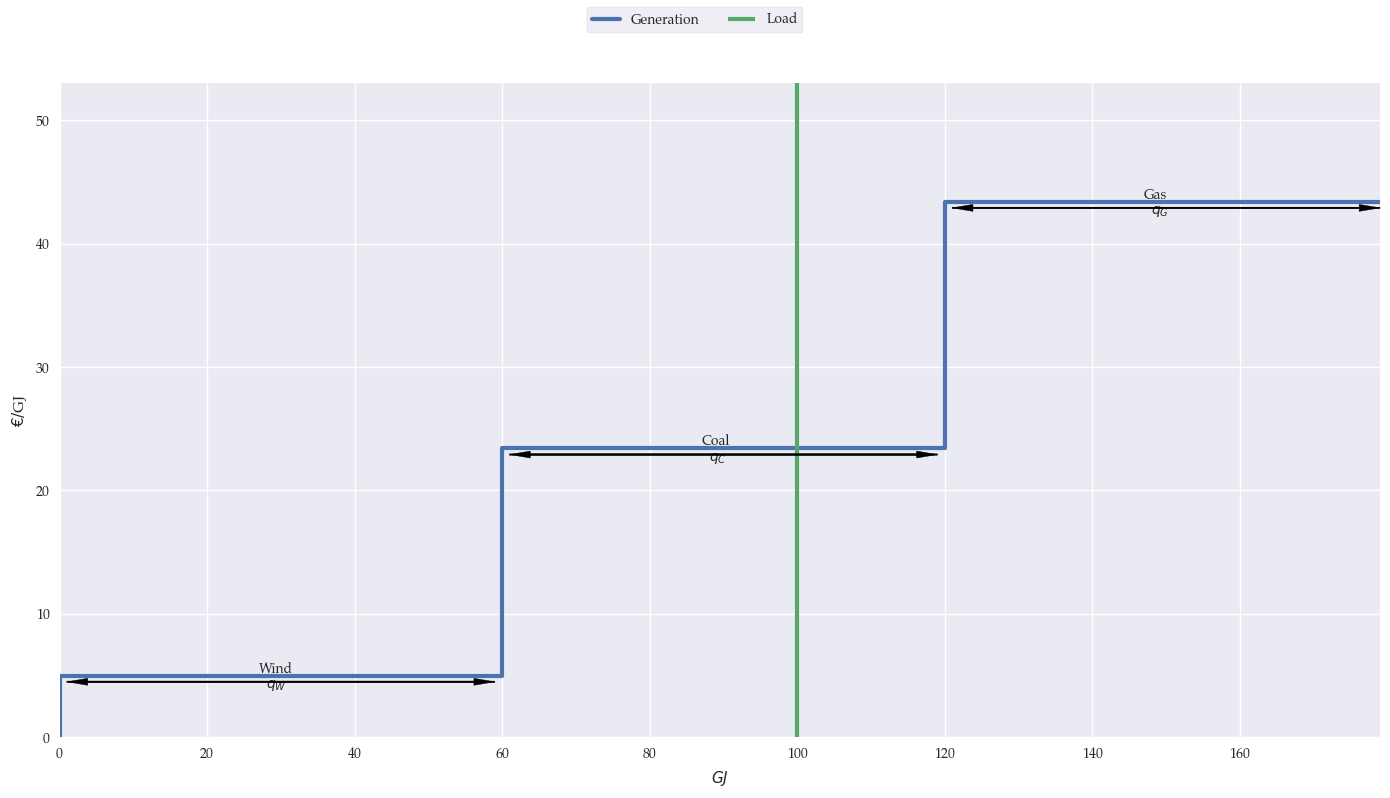

In [8]:
slides = False
if slides:
    fig, ax = plt.subplots(1,1,figsize = (14,10))
else:
    fig, ax = plt.subplots(1,1,figsize = (14,8))    
df.plot(linewidth=3, ax=ax, legend=False);
ax.vlines(db['Load'].sum(), 0, math.ceil(df.max())+4,linewidth=3, color = colors[1]);
ax.set_xlabel(r'$GJ$', labelpad = 5);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);
ax.set_xlim([0, df.index.max()-1]);
ax.set_ylim([0, math.ceil(df.max())+4]);
plt.text(df.index[2]/2-3, df.iloc[2]+0.25, f'Wind');
plt.text(df.index[2]/2-2, df.iloc[2]-1, f'$q_W$');
plt.annotate("",xy=(1, df.iloc[2]-0.5), xytext=(df.index[2]-1, df.iloc[2]-0.5), arrowprops=dict(width=1, color='k', headwidth=5, headlength=15));
plt.annotate("",xy=(df.index[2]-1, df.iloc[2]-0.5), xytext=(1, df.iloc[2]-0.5), arrowprops=dict(width=1, color='k', headwidth=5, headlength=15));

plt.text((df.index[4]+df.index[2])/2-3, df.iloc[4]+0.25, f'Coal')
plt.text((df.index[4]+df.index[2])/2-2, df.iloc[4]-1, f'$q_C$');
plt.annotate("",xy=(df.index[2]+1, df.iloc[4]-0.5), xytext=(df.index[4]-1,df.iloc[4]-0.5), arrowprops=dict(width=1, color='k', headwidth=5, headlength=15));
plt.annotate("",xy=(df.index[4]-1, df.iloc[4]-0.5), xytext=(df.index[2]+1, df.iloc[4]-0.5), arrowprops=dict(width=1, color='k', headwidth=5, headlength=15));

plt.text((df.index[6]+df.index[4])/2-3, df.iloc[6]+0.25, f'Gas')
plt.text((df.index[6]+df.index[4])/2-2, df.iloc[6]-1, f'$q_G$');
plt.annotate("",xy=(df.index[4]+1, df.iloc[6]-0.5), xytext=(df.index[6]-1,df.iloc[6]-0.5), arrowprops=dict(width=1, color='k', headwidth=5, headlength=15));
plt.annotate("",xy=(df.index[6]-1, df.iloc[6]-0.5), xytext=(df.index[4]+1, df.iloc[6]-0.5), arrowprops=dict(width=1, color='k', headwidth=5, headlength=15));

# plt.text((df.index[8]+df.index[6])/2-3, df.iloc[8]+0.25, f'Bio')
# plt.text((df.index[8]+df.index[6])/2-2, df.iloc[8]-1, f'$q_B$');
# plt.annotate("",xy=(df.index[6]+1, df.iloc[8]-0.5), xytext=(df.index[8]-1,df.iloc[8]-0.5), arrowprops=dict(width=1, color='k', headwidth=5, headlength=15));
# plt.annotate("",xy=(df.index[8]-1, df.iloc[8]-0.5), xytext=(df.index[6]+1, df.iloc[8]-0.5), arrowprops=dict(width=1, color='k', headwidth=5, headlength=15));


fig.legend(['Generation', 'Load'],loc=9,ncol=2,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{d['figs']}\\mBasic_MeritOrder2_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:

    fig.savefig(f"{d['figs']}\\mBasic_MeritOrder2.pdf",edgecolor='k')

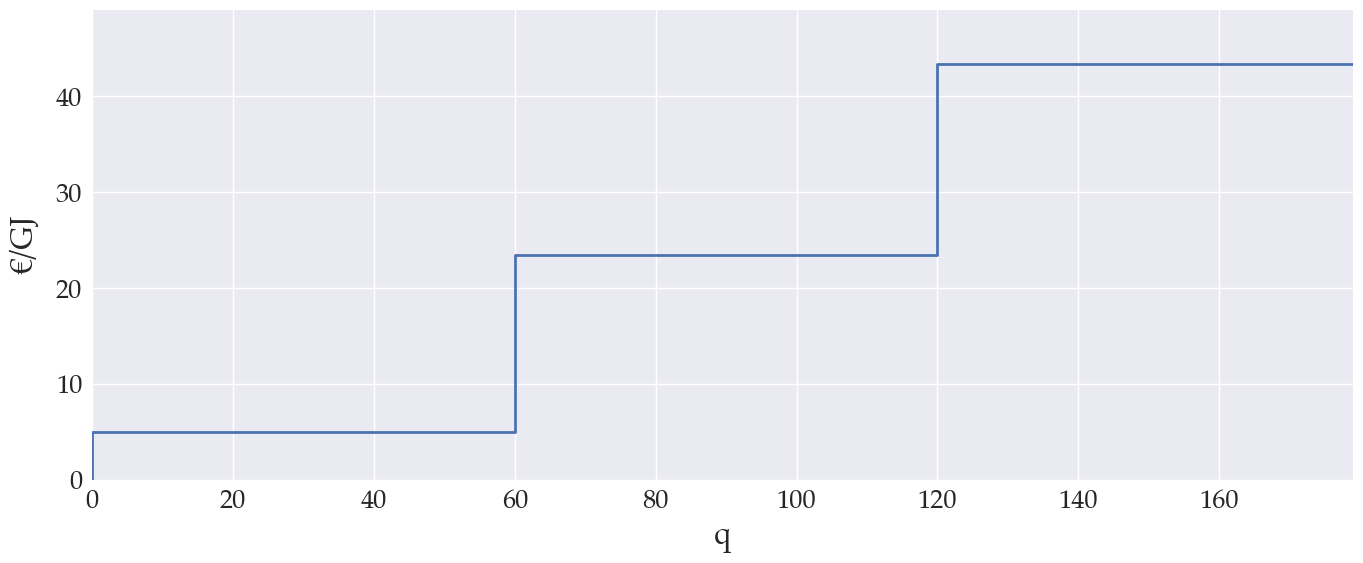

In [9]:
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,6))
df.plot(linewidth=2, ax=ax, legend = False)
ax.set_xlim([0, df.index.max()-1]);
ax.set_ylim([0, math.ceil(df.max())]);
ax.set_ylabel("€/GJ" ,labelpad=10)
fig.tight_layout()

### **Q1.5. A Cap on Emissions**

Assume that, instead of having a price on CO2 emissions $(p_{CO2})$, we implement a cap on CO2 emissions as follows:
\begin{align}
    \sum_i v_i\cdot E_i \leq \overline{CO2}. \tag{4}
\end{align}
*Adjust the Lagrange in (3) appropriately and derive the first order conditions again.*

**Solution:**

$$\begin{align}
\mathcal{L} = - \sum_ic_iE_i+\lambda\left(\sum_i E_i - L \right)+\sum_i\left[\underline{\theta}_iE_i+\overline{\theta}_i\left(q_i-E_i\right)\right] + \theta^{CO2}\left(\overline{CO2}-\sum_iv_i E_i\right).
\end{align}$$

The first order conditions are now:

$$\begin{align}
    -\left(c_i+v_i\cdot \theta^{CO2}\right)+\lambda+\underline{\theta}_i-\overline{\theta}_i = 0
\end{align}$$

as well as the complementary slackness from **Q1.3** and the complementary slackness condition on the emissions cap:

\begin{align}
    \theta^{CO2}(\overline{CO2}-v_iE_i)=0, &&  \overline{CO2}-v_iE_i\geq 0, && \theta^{CO2}\geq 0.
\end{align}

### **Q1.6. Interpretation of shadow variable $\theta^{CO2}$**

In **Q1.4** we used a price on\CO2 emissions of 5€. This resulted in roughly 27.2 tonnes of CO2 emissions in optimum. Now, in the emissions cap scenario (**Q1.5**), let $\theta^{CO2}$ denote the shadow cost of the constraint in (4) and assume that we fix the cap at $\overline{CO2}=$25 tonnes instead. 


*Give an interpretation of what $\theta^{CO2}$ measures. Based on the small data set, what is the value in this model with $\overline{CO2}=$25?*

**Solution:**

$$\begin{align}
    \dfrac{\partial \mathcal{L}}{\partial \overline{CO2}} = \theta^{CO2},
\end{align}$$

where $\mathcal{L}$ coincides with the objective function in optimum. The interpretation is thus that $\overline{\theta}^{CO2}$ measures the change in system costs (our objective function) from marginally increasing the cap on emissions. This is also called the *marginal abatement cost*.



In the small model with three generators, we can only reduce/abate emissions by switching from the coal fired plant to the less dirty natural gas plant (because the only clean wind plant is already used at full capacity). Thus, the marginal abatement cost is defined as the change in system costs that arises from using the natural gas plant (plant B) instead of the coal plant (plant A). Intuitively, this means that:

$$\begin{align}
    \theta^{CO2} = \dfrac{c_B-c_A}{v_A-v_B} \approx \dfrac{41-20}{0.68-0.41} \approx 78.
\end{align}$$

Thus, the cost of reducing 1 ton of emissions is roughly 78 euros. 

## Q2. Numerical implementation

The algorithm in ```scipy.optimize.linprog``` solves what we will refer to as an "augmented form" of the linear program (as opposed to the "standard form" that does not feature explicit equality constraints):

$$\begin{align} 
    &\min_{x}\mbox{ }c^T\cdot x \tag{5a}\\ 
    &A_{ub}\times x \leq b_{ub} \tag{5b}\\ 
    &A_{eq}\times x  = b_{eq} \tag{5c}\\ 
    &l\leq x\leq u, \tag{5d}
\end{align}$$
where: 
* $x$ is the vector of choice variables of length ($N$).
* $c, l, u$ are coefficient vectors of the same length ($N$).
* $b_{eq}, b_{ub}$ are coefficient vectors of lengths $N_{eq}, N_{ub}$, 
* and $A_{eq}, A_{ub}$ are coefficient matrices of sizes $(N_{eq}\times N)$ and $(N_{ub} \times N)$ respectively.

We will generally refer to the inequality constraints $l\leq x \leq u$ as *domain constraints*, whereas the constraints that combine multiple variables as *variational constraints* (1B-1C). 

At its core, the ```scipy.optimize.linprog``` takes inputs in the form of arrays (e.g. ```np.arrays```), which means that we have to be careful with the ordering of variables and constraints: The $n$'th element in $c$ represents the same element as the $n$'th elements in $l,u$ and the $n$'th column vectors in $A_{ub}, A_{eq}$. Thus, when solving a model with many different types of constraints and variables, the task of constructing suitable vectors / matrices becomes quite cumbersome. In the simple model from **Q1**, however, it is very simple.

### **Q2.1. Set up relevant vectors and matrices for the model in Q1.3. Solve it numerically.**

*Hint: You need to create relevant components (```c```, ```b_eq```, ```A_eq```, ```l```, ```u```) and then call*

```python
optimize.linprog(c, A_eq = A_eq, b_eq = b_eq, bounds = np.vstack([l, u]).T)
```

**Solution:**

We've already computed the marginal costs earlier. This is the vector ```c```:

In [10]:
c = mc

The lower bound on generation is zero for all three plants. The upper bound is the ```GeneratingCapacity```:

In [11]:
l = np.zeros(len(mc)) # this creates a vector of three zeros
u = db['GeneratingCapacity'] 

The equilibrium condition is a single condition. In vector/matrix form this translates into $b_{eq} = L$ (the fixed load) and $A_{eq} = \begin{pmatrix} 1 & 1 & 1\end{pmatrix}$ to indicate that each variable $(E_i$) is added with weights $1$ in the equilibrium condition.

In [12]:
b_eq = sum(db['Load'])
A_eq = np.ones((1,len(mc))) 

We can now solve the model using the syntax:

In [13]:
sol = optimize.linprog(c, A_eq = A_eq, b_eq = b_eq, bounds = np.vstack([l, u]).T)
sol

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 1236.2819167208515
              x: [ 4.000e+01  0.000e+00  6.000e+01]
            nit: 1
          lower:  residual: [ 4.000e+01  0.000e+00  6.000e+01]
                 marginals: [ 0.000e+00  1.998e+01  0.000e+00]
          upper:  residual: [ 2.000e+01  6.000e+01  0.000e+00]
                 marginals: [ 0.000e+00  0.000e+00 -1.841e+01]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [ 2.341e+01]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

### **Q2.2. Add the emission cap from (4) with $\overline{CO2} = 25$ to the model and solve.**

**Solution:**

The emission cap is an inequality constraint with emission intensities $\nu$ as weights in the $A_{ub}$ matrix. We computed this as a vector previously, now we need to add it as a matrix with 3 columns insted:

In [14]:
b_ub = 25
A_ub = ν.values.reshape((1,len(ν))) 

We can solve using the same syntax, but with added inequality constraint:

In [15]:
sol = optimize.linprog(c, A_eq = A_eq, b_eq = b_eq, A_ub = A_ub, b_ub = b_ub, bounds = np.vstack([l, u]).T)
sol

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 1398.0391058234395
              x: [ 3.190e+01  8.097e+00  6.000e+01]
            nit: 2
          lower:  residual: [ 3.190e+01  8.097e+00  6.000e+01]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00]
          upper:  residual: [ 2.810e+01  5.190e+01  0.000e+00]
                 marginals: [ 0.000e+00  0.000e+00 -6.886e+01]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [ 7.386e+01]
        ineqlin:  residual: [ 0.000e+00]
                 marginals: [-7.425e+01]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0